# Sky Matching 

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Table of Contents

[Introduction](#intro) <br>

[1. Retrieve Observations using Astroquery](#retrieve) <br>
- [Move files to the local directory](#move) <br>
- [Inspect the image headers](#inspect) <br>

[2. Align the visit-level drizzled data](#align) <br>

[3. Compare `skymethod` options in AstroDrizzle](#compare) <br>
- [`skymethod = 'localmin'`](#localmin) <br>
- [`skymethod = 'match'`](#match) <br>
- [`skymethod = 'globalmin+match'`](#globalminmatch) <br>
- [`skymethod = 'globalmin'`](#globalmin) <br>

[4. Compare the MDRIZSKY values for each method](#mdrizsky) <br>

[5. Display the full 'matched' mosaic](#display) <br>

## Introduction <a id="intro"></a>

When a user decided to mosaic several images it can be difficult to decide how to relate the background of one image to the others. AstroDrizzle has the ability to compute and then either subtract or equalize the background in input images in order to match the sky between those images. The function allows users to select the algorithm for the sky subtraction using the `skymethod` parameter. 

There are four methods available in sky matching: 'localmin', 'match', 'globalmin', 'globalmin+match'.

By applying `drizzlepac.sky.sky()`, or by applying the `skymethod` parameter in the call to `drizzlepac.astrodrizzle.AstroDrizzle()`, AstroDrizzle will update the keyword `MDRIZSKY` in the headers of the input files. 

The **recommended** use for images with sparse fields that have few astronomical sources is `skymethod = localmin` and for images with complicated backgrounds, such as nebulae and large host galaxies, `skymethod = match` is recommended.

For more information on the specifics of this function please refer to the documentation [here](https://drizzlepac.readthedocs.io/en/deployment/sky.html#drizzlepac.sky.sky).

Below, each of the four methods will be demonstrated using a single example dataset, and differences between the methods will be highlighted. 

In [1]:
# All imports needed through out this notebook are included at the beginning. 
import glob
from shutil import copyfile

from astropy.io import fits
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
import matplotlib.pyplot as plt
import pandas as pd

import drizzlepac
from drizzlepac import tweakreg
from drizzlepac import tweakback

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## 1. Retrieve Observations using Astroquery <a id="retrieve"></a>

WFC3/IR observations of the Horsehead Nebula obtained in HST proposal 12812 (PI: Levay) will be used for this demonstration. The images have been processed by the HST WFC3 pipeline (calwf3), which includes bias subtraction, dark current correction, cosmic-ray rejection, and flatfielding.

The alignment specifics for this example are based on the example found [here](https://archive.stsci.edu/prepds/heritage/horsehead/readme_HLSP_v3.txt). We will provide explanation about the process as we go. 

The code used to retrieve the data from astroquery is below.

In [2]:
# Retrieve the observation information.
obs_table = Observations.query_criteria(proposal_id='12812', filters=["F160W"], project='HST')
obs_table.show_in_notebook()

# Figure out the downloadable products:
dataProductsByObservation = Observations.get_product_list(obs_table)
dataProductsByObservation.show_in_notebook()

# Download the flc.fits files: 
obsids = obs_table['obsid']

# Download the data - uncomment to download: 
Observations.download_products(obsids, mrp_only=False, productSubGroupDescription=['FLT', 'DRZ'])

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str99,str8,object,object
./mastDownload/HLA/hst_12812_58_wfc3_ir_f160w_01/hst_12812_58_wfc3_ir_f160w_01_drz.fits,COMPLETE,None,None
./mastDownload/HLA/hst_12812_58_wfc3_ir_f160w_02/hst_12812_58_wfc3_ir_f160w_02_drz.fits,COMPLETE,None,None
./mastDownload/HLA/hst_12812_58_wfc3_ir_f160w/hst_12812_58_wfc3_ir_f160w_drz.fits,COMPLETE,None,None
./mastDownload/HST/ibxl58sqq/ibxl58sqq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl58svq/ibxl58svq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl58030/ibxl58030_drz.fits,COMPLETE,None,None
./mastDownload/HST/hst_12812_58_wfc3_ir_f160w_ibxl58sq/hst_12812_58_wfc3_ir_f160w_ibxl58sq_drz.fits,COMPLETE,None,None
./mastDownload/HST/hst_12812_58_wfc3_ir_f160w_ibxl58sq/hst_12812_58_wfc3_ir_f160w_ibxl58sq_flt.fits,COMPLETE,None,None
./mastDownload/HST/hst_12812_58_wfc3_ir_f160w_ibxl58sv/hst_12812_58_wfc3_ir_f160w_ibxl58sv_drz.fits,COMPLETE,None,None


### Move files to the local directory <a id="move"></a>

In [3]:
flt_files = glob.glob('mastDownload/*/*/*flt.fits')

for file in flt_files:
    with fits.open(file) as im:
        rootname = im[0].header['ROOTNAME']
    dst = rootname + "_flt.fits"
    copyfile(file, dst)

drz_files = glob.glob('mastDownload/*/*/*drz.fits')

for file in drz_files:
    with fits.open(file) as im:
        rootname = im[0].header['ROOTNAME']
    dst = rootname + "_drz.fits"
    copyfile(file, dst)

### Inspect the image headers <a id="inspect"></a>

In [4]:
# FLT images
collect_flt = ImageFileCollection('./', glob_include="*flt.fits", ext=0,
                                  keywords=["asn_id", "detector", "filter", "exptime", "postarg1", "postarg2"])
    
flt_table = collect_flt.summary
flt_table['exptime'].format = '7.1f'
flt_table['postarg1'].format = '7.2f'
flt_table['postarg2'].format = '7.2f'
flt_table

file,asn_id,detector,filter,exptime,postarg1,postarg2
str18,str9,str2,str5,float64,float64,float64
ibxl50clq_flt.fits,IBXL50030,IR,F160W,702.9,-123.74,-113.11
ibxl50cqq_flt.fits,IBXL50030,IR,F160W,702.9,-123.74,-105.91
ibxl51eoq_flt.fits,IBXL51030,IR,F160W,702.9,0.00,-113.11
ibxl51etq_flt.fits,IBXL51030,IR,F160W,702.9,0.00,-105.91
ibxl52k0q_flt.fits,IBXL52030,IR,F160W,702.9,123.74,-113.11
ibxl52k5q_flt.fits,IBXL52030,IR,F160W,702.9,123.74,-105.91
ibxl53kxq_flt.fits,IBXL53030,IR,F160W,702.9,-123.74,-3.60
ibxl53l9q_flt.fits,IBXL53030,IR,F160W,702.9,-123.74,3.60
ibxl54bgq_flt.fits,IBXL54030,IR,F160W,702.9,0.00,-3.60


In [5]:
# DRZ images
collect_drz = ImageFileCollection('./', glob_include="*drz.fits", ext=0,
                                  keywords=["asn_id", "detector", "filter", "exptime"])
    
drz_table = collect_drz.summary
drz_table['exptime'].format = '7.1f'
drz_table

file,asn_id,detector,filter,exptime
str44,object,str2,str9,float64
hst_12812_50_wfc3_ir_f160w_ibxl50_drz.fits,--,IR,F160W,1405.9
hst_12812_50_wfc3_ir_f160w_ibxl50cl_drz.fits,IBXL50030,IR,F160W,702.9
hst_12812_50_wfc3_ir_f160w_ibxl50cq_drz.fits,IBXL50030,IR,F160W,702.9
hst_12812_50_wfc3_ir_f160w_run_1_drz.fits,IBXL50030,IR,F160W,1405.9
hst_12812_50_wfc3_ir_total_ibxl50_drz.fits,--,IR,detection,2511.8
hst_12812_51_wfc3_ir_f160w_ibxl51_drz.fits,--,IR,F160W,1405.9
hst_12812_51_wfc3_ir_f160w_ibxl51eo_drz.fits,IBXL51030,IR,F160W,702.9
hst_12812_51_wfc3_ir_f160w_ibxl51et_drz.fits,IBXL51030,IR,F160W,702.9
hst_12812_51_wfc3_ir_f160w_run_1_drz.fits,IBXL51030,IR,F160W,1405.9


## 2. Align the visit-level drizzled data <a id="align"></a>

Exposures obtained within a single HST visit tend to be aligned very well since they use the same guide stars. Thus, we will use TweakReg to align the DRZ files and then use TweakBack to propagate those solutions back to the FLT image headers prior to combining with AstroDrizzle. Making use of the parameter `expand_refcat`, TweakReg will build up an expanded reference catalog on the sky to be used for alignment. For this dataset, we obtain the best results when we tell TweakReg to align the DRZ files in a specific order, and this is achieved by giving a list of files as input. More details on alignment of HST mosaics can be found in the notebook 'mosaics.ipynb' in this repository.
    
    drz.list
    ibxl54030_drz.fits	<-- Note that tile 54 is the reference and is listed first
    ibxl51030_drz.fits  
    ibxl53030_drz.fits
    ibxl55030_drz.fits
    ibxl57030_drz.fits
    ibxl50030_drz.fits
    ibxl52030_drz.fits
    ibxl56030_drz.fits
    ibxl58030_drz.fits
      ____ ____ ____
     |    |    |    |    <-- The 4 tiles with the most overlap are aligned first
     |    | 55 |    |
     |____|____|____|
     |    |    |    |
     | 57 | 54 | 51 |
     |____|____|____|
     |    |    |    |
     |    | 53 |    |
     |____|____|____|
   
      ____ ____ ____
     |    |    |    |    <-- Then the corner tiles are added 
     | 58 |    | 52 |
     |____|____|____|
     |    |    |    |
     |    |    |    |
     |____|____|____|
     |    |    |    |
     | 56 |    | 50 |
     |____|____|____|

This allows TweakReg to start with the tiles with the most overlap first and then build upon that, expanding the reference catalog as each new tile is aligned. 

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 16:53:31.794 (19/04/2024) 


TweakReg Version 3.5.1 started at: 16:53:31.794 (19/04/2024) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version 3.11.9 (main, Apr  2 2024, 15:20:57) [GCC 9.4.0]


Python Version 3.11.9 (main, Apr  2 2024, 15:20:57) [GCC 9.4.0]


INFO:drizzlepac.util:numpy Version -> 1.26.4 


numpy Version -> 1.26.4 


INFO:drizzlepac.util:astropy Version -> 5.3.3 


astropy Version -> 5.3.3 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.12.0 


photutils Version -> 1.12.0 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	input :	@drz.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakutils:ibxl54030_drz.fits


ibxl54030_drz.fits


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ibxl54030_drz.fits


    ibxl54030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl51030_drz.fits


    ibxl51030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl53030_drz.fits


    ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl55030_drz.fits


    ibxl55030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl57030_drz.fits


    ibxl57030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl50030_drz.fits


    ibxl50030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl52030_drz.fits


    ibxl52030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl56030_drz.fits


    ibxl56030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl58030_drz.fits


    ibxl58030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	4.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	@drz.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	1


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	5


INFO:drizzlepac.tweakreg:	updatehdr :	True


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl54030_drz.fits':


===  Source finding for image 'ibxl54030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl54030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.16 (19/04/2024)


  #  Source finding for 'ibxl54030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.16 (19/04/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.542215


INFO:drizzlepac.catalogs:###Source finding finished at: 16:53:32.22 (19/04/2024)


INFO:drizzlepac.catalogs:     Found 36 objects.


     Found 36 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl54030_drz.fits': 36


===  FINAL number of objects in image 'ibxl54030_drz.fits': 36


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl51030_drz.fits':


===  Source finding for image 'ibxl51030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl51030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.288 (19/04/2024)


  #  Source finding for 'ibxl51030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.288 (19/04/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.554411


INFO:drizzlepac.catalogs:###Source finding finished at: 16:53:32.346 (19/04/2024)


INFO:drizzlepac.catalogs:     Found 59 objects.


     Found 59 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl51030_drz.fits': 59


===  FINAL number of objects in image 'ibxl51030_drz.fits': 59


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl53030_drz.fits':


===  Source finding for image 'ibxl53030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl53030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.410 (19/04/2024)


  #  Source finding for 'ibxl53030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.410 (19/04/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.528417


INFO:drizzlepac.catalogs:###Source finding finished at: 16:53:32.471 (19/04/2024)


INFO:drizzlepac.catalogs:     Found 30 objects.


     Found 30 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl53030_drz.fits': 30


===  FINAL number of objects in image 'ibxl53030_drz.fits': 30


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl55030_drz.fits':


===  Source finding for image 'ibxl55030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl55030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.534 (19/04/2024)


  #  Source finding for 'ibxl55030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.534 (19/04/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.261234


INFO:drizzlepac.catalogs:###Source finding finished at: 16:53:32.592 (19/04/2024)


INFO:drizzlepac.catalogs:     Found 76 objects.


     Found 76 objects.


  orient = great_circle_arc.triple_product(A-B, C-B, B)



  orient = great_circle_arc.triple_product(A-B, C-B, B)



INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl55030_drz.fits': 76


===  FINAL number of objects in image 'ibxl55030_drz.fits': 76


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl57030_drz.fits':


===  Source finding for image 'ibxl57030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl57030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.657 (19/04/2024)


  #  Source finding for 'ibxl57030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.657 (19/04/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.506827


INFO:drizzlepac.catalogs:###Source finding finished at: 16:53:32.716 (19/04/2024)


INFO:drizzlepac.catalogs:     Found 70 objects.


     Found 70 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl57030_drz.fits': 70


===  FINAL number of objects in image 'ibxl57030_drz.fits': 70


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl50030_drz.fits':


===  Source finding for image 'ibxl50030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl50030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.778 (19/04/2024)


  #  Source finding for 'ibxl50030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.778 (19/04/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.558161


INFO:drizzlepac.catalogs:###Source finding finished at: 16:53:32.837 (19/04/2024)


INFO:drizzlepac.catalogs:     Found 54 objects.


     Found 54 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl50030_drz.fits': 54


===  FINAL number of objects in image 'ibxl50030_drz.fits': 54


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl52030_drz.fits':


===  Source finding for image 'ibxl52030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl52030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.89 (19/04/2024)


  #  Source finding for 'ibxl52030_drz.fits', EXT=('SCI', 1) started at: 16:53:32.89 (19/04/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.234315


INFO:drizzlepac.catalogs:###Source finding finished at: 16:53:32.958 (19/04/2024)


INFO:drizzlepac.catalogs:     Found 62 objects.


     Found 62 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl52030_drz.fits': 62


===  FINAL number of objects in image 'ibxl52030_drz.fits': 62


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl56030_drz.fits':


===  Source finding for image 'ibxl56030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl56030_drz.fits', EXT=('SCI', 1) started at: 16:53:33.02 (19/04/2024)


  #  Source finding for 'ibxl56030_drz.fits', EXT=('SCI', 1) started at: 16:53:33.02 (19/04/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.618534


INFO:drizzlepac.catalogs:###Source finding finished at: 16:53:33.078 (19/04/2024)


INFO:drizzlepac.catalogs:     Found 51 objects.


     Found 51 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl56030_drz.fits': 51


===  FINAL number of objects in image 'ibxl56030_drz.fits': 51


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl58030_drz.fits':


===  Source finding for image 'ibxl58030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl58030_drz.fits', EXT=('SCI', 1) started at: 16:53:33.141 (19/04/2024)


  #  Source finding for 'ibxl58030_drz.fits', EXT=('SCI', 1) started at: 16:53:33.141 (19/04/2024)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.247161


INFO:drizzlepac.catalogs:###Source finding finished at: 16:53:33.200 (19/04/2024)


INFO:drizzlepac.catalogs:     Found 80 objects.


     Found 80 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl58030_drz.fits': 80


===  FINAL number of objects in image 'ibxl58030_drz.fits': 80


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "ibxl54030_drz.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'ibxl54030_drz.fits'


derived from 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	5


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	1


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	True


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	rscale


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	5


INFO:drizzlepac.tweakreg:	nclip :	1


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	0.5


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	shift4_drc.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl51030_drz.fits


Performing fit for: ibxl51030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl51030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl51030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.3138, -0.1306 with significance of 4.082 and 9 matches


Found initial X and Y shifts of 0.3138, -0.1306 with significance of 4.082 and 9 matches


INFO:drizzlepac.imgclasses:Found 8 matches for ibxl51030_drz.fits...


Found 8 matches for ibxl51030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl51030_drz.fits : 


Computed  rscale  fit for  ibxl51030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0712  YSH: -0.3568    ROT: 359.9930094    SCALE: 0.999948


XSH: 0.0712  YSH: -0.3568    ROT: 359.9930094    SCALE: 0.999948


INFO:drizzlepac.imgclasses:FIT XRMS: 0.21       FIT YRMS: 0.16   


FIT XRMS: 0.21       FIT YRMS: 0.16   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.27       FIT MAE: 0.19   


FIT RMSE: 0.27       FIT MAE: 0.19   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 8.6e-06 (deg)   RMS_DEC: 3.9e-06 (deg)


RMS_RA: 8.6e-06 (deg)   RMS_DEC: 3.9e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  8  objects.


Final solution based on  8  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl51030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl51030_drz_catalog_fit.match


wrote XY data to:  ibxl51030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 8


Total # points: 8


INFO:drizzlepac.tweakutils:# of points after clipping: 8


# of points after clipping: 8


INFO:drizzlepac.tweakutils:Total # points: 8


Total # points: 8


INFO:drizzlepac.tweakutils:# of points after clipping: 8


# of points after clipping: 8


INFO:drizzlepac.imgclasses:Adding 51 new sources to the reference catalog for a total of 87 sources.


Adding 51 new sources to the reference catalog for a total of 87 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl51030_drz.fits' ...


....Updating header for 'ibxl51030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl51030_drz.fits['SCI',1]


Processing ibxl51030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl51030_drz.fits[1]


Updating header for ibxl51030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.471272457357326e-05 8.0187078736901e-06


CD_11  CD_12: 3.471272457357326e-05 8.0187078736901e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.018707877014154e-06 -3.4712724554353455e-05


CD_21  CD_22: 8.018707877014154e-06 -3.4712724554353455e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.26168155352705 -2.4828717444323356


CRVAL    : 85.26168155352705 -2.4828717444323356


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.1282500028610228


Plate Scale : 0.1282500028610228


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.99272293434032


ORIENTAT : 166.99272293434032


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl53030_drz.fits


Performing fit for: ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 4 matches


Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 4 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl53030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl53030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl55030_drz.fits


Performing fit for: ibxl55030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl55030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl55030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, -0.1306 with significance of 3.266 and 6 matches


Found initial X and Y shifts of 0.2027, -0.1306 with significance of 3.266 and 6 matches


INFO:drizzlepac.imgclasses:Found 6 matches for ibxl55030_drz.fits...


Found 6 matches for ibxl55030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl55030_drz.fits : 


Computed  rscale  fit for  ibxl55030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0484  YSH: -0.1772    ROT: 359.9770999    SCALE: 0.999646


XSH: -0.0484  YSH: -0.1772    ROT: 359.9770999    SCALE: 0.999646


INFO:drizzlepac.imgclasses:FIT XRMS: 0.04       FIT YRMS: 0.027  


FIT XRMS: 0.04       FIT YRMS: 0.027  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.048      FIT MAE: 0.047  


FIT RMSE: 0.048      FIT MAE: 0.047  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.6e-06 (deg)   RMS_DEC: 6.2e-07 (deg)


RMS_RA: 1.6e-06 (deg)   RMS_DEC: 6.2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  6  objects.


Final solution based on  6  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl55030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl55030_drz_catalog_fit.match


wrote XY data to:  ibxl55030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 6


Total # points: 6


INFO:drizzlepac.tweakutils:# of points after clipping: 6


# of points after clipping: 6


INFO:drizzlepac.tweakutils:Total # points: 6


Total # points: 6


INFO:drizzlepac.tweakutils:# of points after clipping: 6


# of points after clipping: 6


INFO:drizzlepac.imgclasses:Adding 70 new sources to the reference catalog for a total of 157 sources.


Adding 70 new sources to the reference catalog for a total of 157 sources.


  orient = great_circle_arc.triple_product(A-B, C-B, B)



  orient = great_circle_arc.triple_product(A-B, C-B, B)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl55030_drz.fits' ...


....Updating header for 'ibxl55030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl55030_drz.fits['SCI',1]


Processing ibxl55030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl55030_drz.fits[1]


Updating header for ibxl55030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.4721216282121534e-05 8.029738986119495e-06


CD_11  CD_12: 3.4721216282121534e-05 8.029738986119495e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.029738989860642e-06 -3.472121626448824e-05


CD_21  CD_22: 8.029738989860642e-06 -3.472121626448824e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.22117083306539 -2.461203544648631


CRVAL    : 85.22117083306539 -2.461203544648631


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102267


Plate Scale : 0.12825000286102267


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.97851571583033


ORIENTAT : 166.97851571583033


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl57030_drz.fits


Performing fit for: ibxl57030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl57030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl57030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 5 matches


Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 5 matches


INFO:drizzlepac.imgclasses:Found 5 matches for ibxl57030_drz.fits...


Found 5 matches for ibxl57030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl57030_drz.fits : 


Computed  rscale  fit for  ibxl57030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.1407  YSH: -0.2080    ROT: 359.9750577    SCALE: 0.999677


XSH: -0.1407  YSH: -0.2080    ROT: 359.9750577    SCALE: 0.999677


INFO:drizzlepac.imgclasses:FIT XRMS: 0.051      FIT YRMS: 0.041  


FIT XRMS: 0.051      FIT YRMS: 0.041  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.065      FIT MAE: 0.061  


FIT RMSE: 0.065      FIT MAE: 0.061  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.1e-06 (deg)   RMS_DEC: 1e-06 (deg)


RMS_RA: 2.1e-06 (deg)   RMS_DEC: 1e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  5  objects.


Final solution based on  5  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl57030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl57030_drz_catalog_fit.match


wrote XY data to:  ibxl57030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 5


Total # points: 5


INFO:drizzlepac.tweakutils:# of points after clipping: 5


# of points after clipping: 5


INFO:drizzlepac.tweakutils:Total # points: 5


Total # points: 5


INFO:drizzlepac.tweakutils:# of points after clipping: 5


# of points after clipping: 5


INFO:drizzlepac.imgclasses:Adding 65 new sources to the reference catalog for a total of 222 sources.


Adding 65 new sources to the reference catalog for a total of 222 sources.


  orient = great_circle_arc.triple_product(A-B, C-B, B)



  orient = great_circle_arc.triple_product(A-B, C-B, B)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl57030_drz.fits' ...


....Updating header for 'ibxl57030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl57030_drz.fits['SCI',1]


Processing ibxl57030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl57030_drz.fits[1]


Updating header for ibxl57030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.4719698846175465e-05 8.031397848916461e-06


CD_11  CD_12: 3.4719698846175465e-05 8.031397848916461e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.03139785160009e-06 -3.471969882244847e-05


CD_21  CD_22: 8.03139785160009e-06 -3.471969882244847e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.24776030811763 -2.42368224831165


CRVAL    : 85.24776030811763 -2.42368224831165


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102267


Plate Scale : 0.12825000286102267


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.97536749833117


ORIENTAT : 166.97536749833117


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl50030_drz.fits


Performing fit for: ibxl50030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl50030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl50030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 6 matches


Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 6 matches


INFO:drizzlepac.imgclasses:Found 6 matches for ibxl50030_drz.fits...


Found 6 matches for ibxl50030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl50030_drz.fits : 


Computed  rscale  fit for  ibxl50030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.1043  YSH: -0.1336    ROT: 359.9991954    SCALE: 0.999852


XSH: -0.1043  YSH: -0.1336    ROT: 359.9991954    SCALE: 0.999852


INFO:drizzlepac.imgclasses:FIT XRMS: 0.023      FIT YRMS: 0.043  


FIT XRMS: 0.023      FIT YRMS: 0.043  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.049      FIT MAE: 0.043  


FIT RMSE: 0.049      FIT MAE: 0.043  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  6  objects.


Final solution based on  6  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl50030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl50030_drz_catalog_fit.match


wrote XY data to:  ibxl50030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 6


Total # points: 6


INFO:drizzlepac.tweakutils:# of points after clipping: 6


# of points after clipping: 6


INFO:drizzlepac.tweakutils:Total # points: 6


Total # points: 6


INFO:drizzlepac.tweakutils:# of points after clipping: 6


# of points after clipping: 6


INFO:drizzlepac.imgclasses:Adding 48 new sources to the reference catalog for a total of 270 sources.


Adding 48 new sources to the reference catalog for a total of 270 sources.


  orient = great_circle_arc.triple_product(A-B, C-B, B)



  orient = great_circle_arc.triple_product(A-B, C-B, B)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl50030_drz.fits' ...


....Updating header for 'ibxl50030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl50030_drz.fits['SCI',1]


Processing ibxl50030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl50030_drz.fits[1]


Updating header for ibxl50030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.5191377289030756e-05 5.575336809618214e-06


CD_11  CD_12: 3.5191377289030756e-05 5.575336809618214e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 5.575336823150422e-06 -3.519137728638346e-05


CD_21  CD_22: 5.575336823150422e-06 -3.519137728638346e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.29354055830704 -2.477715834088767


CRVAL    : 85.29354055830704 -2.477715834088767


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.1282500028610227


Plate Scale : 0.1282500028610227


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 170.99750608276906


ORIENTAT : 170.99750608276906


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl52030_drz.fits


Performing fit for: ibxl52030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl52030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl52030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, 0.2027 with significance of 6.674 and 14 matches


Found initial X and Y shifts of 0.2027, 0.2027 with significance of 6.674 and 14 matches


INFO:drizzlepac.imgclasses:Found 9 matches for ibxl52030_drz.fits...


Found 9 matches for ibxl52030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl52030_drz.fits : 


Computed  rscale  fit for  ibxl52030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.3065  YSH: -0.5913    ROT: 359.998901    SCALE: 1.000500


XSH: 0.3065  YSH: -0.5913    ROT: 359.998901    SCALE: 1.000500


INFO:drizzlepac.imgclasses:FIT XRMS: 0.17       FIT YRMS: 0.18   


FIT XRMS: 0.17       FIT YRMS: 0.18   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.25       FIT MAE: 0.23   


FIT RMSE: 0.25       FIT MAE: 0.23   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.4e-06 (deg)   RMS_DEC: 5e-06 (deg)


RMS_RA: 7.4e-06 (deg)   RMS_DEC: 5e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  9  objects.


Final solution based on  9  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl52030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl52030_drz_catalog_fit.match


wrote XY data to:  ibxl52030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 9


Total # points: 9


INFO:drizzlepac.tweakutils:# of points after clipping: 9


# of points after clipping: 9


INFO:drizzlepac.tweakutils:Total # points: 9


Total # points: 9


INFO:drizzlepac.tweakutils:# of points after clipping: 9


# of points after clipping: 9


INFO:drizzlepac.imgclasses:Adding 53 new sources to the reference catalog for a total of 323 sources.


Adding 53 new sources to the reference catalog for a total of 323 sources.


  orient = great_circle_arc.triple_product(A-B, C-B, B)



  orient = great_circle_arc.triple_product(A-B, C-B, B)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl52030_drz.fits' ...


....Updating header for 'ibxl52030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl52030_drz.fits['SCI',1]


Processing ibxl52030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl52030_drz.fits[1]


Updating header for ibxl52030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.469459379065508e-05 8.00987087575203e-06


CD_11  CD_12: 3.469459379065508e-05 8.00987087575203e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.00987087352115e-06 -3.469459378348872e-05


CD_21  CD_22: 8.00987087352115e-06 -3.469459378348872e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.22835887372167 -2.4908295977407686


CRVAL    : 85.22835887372167 -2.4908295977407686


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102267


Plate Scale : 0.12825000286102267


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 167.0000113401778


ORIENTAT : 167.0000113401778


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl56030_drz.fits


Performing fit for: ibxl56030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl56030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl56030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.5777, -0.7973 with significance of 4.472 and 8 matches


Found initial X and Y shifts of 0.5777, -0.7973 with significance of 4.472 and 8 matches


INFO:drizzlepac.imgclasses:Found 8 matches for ibxl56030_drz.fits...


Found 8 matches for ibxl56030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl56030_drz.fits : 


Computed  rscale  fit for  ibxl56030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2203  YSH: -0.8909    ROT: 359.9715644    SCALE: 1.000371


XSH: -0.2203  YSH: -0.8909    ROT: 359.9715644    SCALE: 1.000371


INFO:drizzlepac.imgclasses:FIT XRMS: 0.28       FIT YRMS: 0.21   


FIT XRMS: 0.28       FIT YRMS: 0.21   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.35       FIT MAE: 0.26   


FIT RMSE: 0.35       FIT MAE: 0.26   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.1e-05 (deg)   RMS_DEC: 5.2e-06 (deg)


RMS_RA: 1.1e-05 (deg)   RMS_DEC: 5.2e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  8  objects.


Final solution based on  8  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl56030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl56030_drz_catalog_fit.match


wrote XY data to:  ibxl56030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 8


Total # points: 8


INFO:drizzlepac.tweakutils:# of points after clipping: 8


# of points after clipping: 8


INFO:drizzlepac.tweakutils:Total # points: 8


Total # points: 8


INFO:drizzlepac.tweakutils:# of points after clipping: 8


# of points after clipping: 8


INFO:drizzlepac.imgclasses:Adding 43 new sources to the reference catalog for a total of 366 sources.


Adding 43 new sources to the reference catalog for a total of 366 sources.


  orient = great_circle_arc.triple_product(A-B, C-B, B)



  orient = great_circle_arc.triple_product(A-B, C-B, B)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl56030_drz.fits' ...


....Updating header for 'ibxl56030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl56030_drz.fits['SCI',1]


Processing ibxl56030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl56030_drz.fits[1]


Updating header for ibxl56030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.405038098025548e-05 1.0429369575469343e-05


CD_11  CD_12: 3.405038098025548e-05 1.0429369575469343e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0429369580256274e-05 -3.4050380988186895e-05


CD_21  CD_22: 1.0429369580256274e-05 -3.4050380988186895e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.2785750056112 -2.4139806008804


CRVAL    : 85.2785750056112 -2.4139806008804


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102275


Plate Scale : 0.12825000286102275


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 162.9705767943431


ORIENTAT : 162.9705767943431


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl58030_drz.fits


Performing fit for: ibxl58030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl58030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl58030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.3277, -0.5473 with significance of 9.258 and 16 matches


Found initial X and Y shifts of 0.3277, -0.5473 with significance of 9.258 and 16 matches


INFO:drizzlepac.imgclasses:Found 14 matches for ibxl58030_drz.fits...


Found 14 matches for ibxl58030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl58030_drz.fits : 


Computed  rscale  fit for  ibxl58030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.1874  YSH: 0.4222    ROT: 359.960672    SCALE: 1.000627


XSH: 0.1874  YSH: 0.4222    ROT: 359.960672    SCALE: 1.000627


INFO:drizzlepac.imgclasses:FIT XRMS: 0.1        FIT YRMS: 0.11   


FIT XRMS: 0.1        FIT YRMS: 0.11   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.15       FIT MAE: 0.13   


FIT RMSE: 0.15       FIT MAE: 0.13   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.5e-06 (deg)   RMS_DEC: 3e-06 (deg)


RMS_RA: 4.5e-06 (deg)   RMS_DEC: 3e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  13  objects.


Final solution based on  13  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl58030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl58030_drz_catalog_fit.match


wrote XY data to:  ibxl58030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 13


Total # points: 13


INFO:drizzlepac.tweakutils:# of points after clipping: 13


# of points after clipping: 13


INFO:drizzlepac.tweakutils:Total # points: 13


Total # points: 13


INFO:drizzlepac.tweakutils:# of points after clipping: 13


# of points after clipping: 13


INFO:drizzlepac.imgclasses:Adding 66 new sources to the reference catalog for a total of 432 sources.


Adding 66 new sources to the reference catalog for a total of 432 sources.


  orient = great_circle_arc.triple_product(A-B, C-B, B)



  orient = great_circle_arc.triple_product(A-B, C-B, B)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl58030_drz.fits' ...


....Updating header for 'ibxl58030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl58030_drz.fits['SCI',1]


Processing ibxl58030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl58030_drz.fits[1]


Updating header for ibxl58030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.4684934962834206e-05 8.031636745768284e-06


CD_11  CD_12: 3.4684934962834206e-05 8.031636745768284e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.03163673550717e-06 -3.468493491086287e-05


CD_21  CD_22: 8.03163673550717e-06 -3.468493491086287e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.21415443603887 -2.431619771646182


CRVAL    : 85.21415443603887 -2.431619771646182


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102253


Plate Scale : 0.12825000286102253


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.96238440247274


ORIENTAT : 166.96238440247274


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl53030_drz.fits


Performing fit for: ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.5865, 0.6448 with significance of 6.461 and 17 matches


Found initial X and Y shifts of 0.5865, 0.6448 with significance of 6.461 and 17 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl53030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl53030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Unable to match the following images:


Unable to match the following images:


INFO:drizzlepac.tweakreg:-------------------------------------


-------------------------------------


INFO:drizzlepac.tweakreg:ibxl53030_drz.fits


ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibxl54030_drz.fits['SCI',1]


Processing ibxl54030_drz.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibxl54030_drz.fits[('SCI', 1)]


Updating header for ibxl54030_drz.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.47119359474506e-05 8.0138744939321e-06


CD_11  CD_12: 3.47119359474506e-05 8.0138744939321e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.0138744939321e-06 -3.471193594745e-05


CD_21  CD_22: 8.0138744939321e-06 -3.471193594745e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.25465874630264 -2.4532704798615486


CRVAL    : 85.25465874630264 -2.4532704798615486


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 508.0


CRPIX    : 542.0 508.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1016


NAXIS    : 1084 1016


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102273


Plate Scale : 0.12825000286102273


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 167.0000115473907


ORIENTAT : 167.0000115473907


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibxl53030_drz.fits['SCI',1]


Processing ibxl53030_drz.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibxl53030_drz.fits[('SCI', 1)]


Updating header for ibxl53030_drz.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.45665765309805e-05 8.61930789288078e-06


CD_11  CD_12: 3.45665765309805e-05 8.61930789288078e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.61930789288078e-06 -3.456657653098e-05


CD_21  CD_22: 8.61930789288078e-06 -3.456657653098e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.28811142028032 -2.44470347970801


CRVAL    : 85.28811142028032 -2.44470347970801


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102275


Plate Scale : 0.12825000286102275


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 165.99860738183568


ORIENTAT : 165.99860738183568


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


INFO:drizzlepac.tweakutils:Writing out shiftfile : shift4_drc.txt


Writing out shiftfile : shift4_drc.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


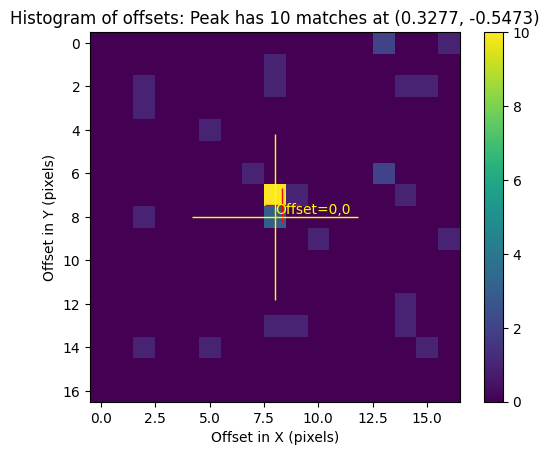

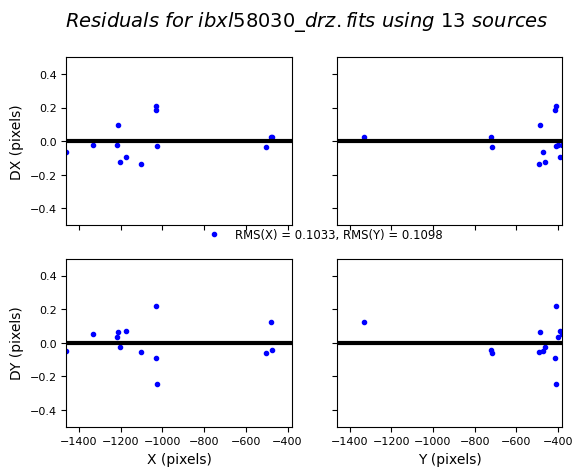

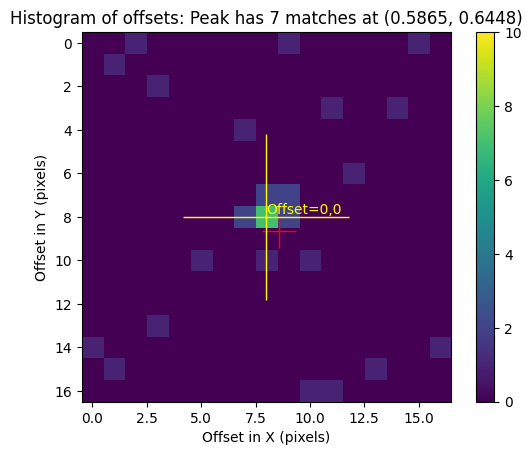

In [6]:
tweakreg.TweakReg('@drz.list', 
                  imagefindcfg={'threshold': 5, 'conv_width': 4.5, 'peakmin': 1}, 
                  minobj=5, 
                  shiftfile=True, 
                  expand_refcat=True, 
                  enforce_user_order=True, 
                  outshifts='shift4_drc.txt',
                  searchrad=1,
                  ylimit=0.5, 
                  tolerance=1,
                  nclip=1,
                  updatehdr=True,
                  interactive=False)

Tweakback is then run on the aligned DRZ files to propogate the updated WCS information back to the FLT files.

In [7]:
drz_files = glob.glob('i*0_drz.fits')

for f in drz_files:
    tb_input = f+'[sci,1]'
    hdu = fits.open(f)
    tweakback.apply_tweak(tb_input, orig_wcs_name=hdu[1].header['WCSNAME'])


*** 'apply_tweak' version 3.5.1 started at 16:53:40.298 (19/04/2024): ***

Using WCS with WCSNAME 'TWEAK' (WCS key ' ') for 'tweaked_wcs_name'

* Setting 'output_wcs_name' to 'TWEAK'

* Working on input image ibxl52k0q_flt.fits ...
  - Computed new WCS solution for ibxl52k0q_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.228409497573  -2.491515214253112
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.663383468236042e-05  7.762687295016628e-06
      CD2_1 CD2_2  : 8.569960209008874e-06  -3.269538524560712e-05
      NAXIS : 1014  1014

* Working on input image ibxl52k5q_flt.fits ...
  - Computed new WCS solution for ibxl52k5q_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.227952883905  -2.489567286208786
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.662749747972769e-05  7.752216900621866e-06
      CD2_1 CD2_

Using WCS with WCSNAME 'TWEAK' (WCS key ' ') for 'tweaked_wcs_name'

* Setting 'output_wcs_name' to 'TWEAK'

* Working on input image ibxl53kxq_flt.fits ...
  - Computed new WCS solution for ibxl53kxq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.288192085903  -2.445403016063309
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.6486200357163236e-05  8.34065572998099e-06
      CD2_1 CD2_2  : 9.216391502893922e-06  -3.2561379431194826e-05
      NAXIS : 1014  1014

* Working on input image ibxl53l9q_flt.fits ...
  - Computed new WCS solution for ibxl53l9q_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.287695517328  -2.4434666946598163
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.6486682691047034e-05  8.34643823537184e-06
      CD2_1 CD2_2  : 9.221635287003772e-06  -3.256154793039286e-05
      NAXIS : 1014  101


* Setting 'output_wcs_name' to 'TWEAK'

* Working on input image ibxl58sqq_flt.fits ...
  - Computed new WCS solution for ibxl58sqq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.214213096183  -2.432290715232297
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.662967293219477e-05  7.757225413503442e-06
      CD2_1 CD2_2  : 8.564778463527945e-06  -3.2691852240188064e-05
      NAXIS : 1014  1014

* Working on input image ibxl58svq_flt.fits ...
  - Computed new WCS solution for ibxl58svq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.213752405793  -2.430346496271999
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.662687239515882e-05  7.756157816861389e-06
      CD2_1 CD2_2  : 8.56369582038951e-06  -3.2689373112758434e-05
      NAXIS : 1014  1014

* Saving updated WCS to image headers:
  - Updated 'ibxl58sqq_flt.


* Setting 'output_wcs_name' to 'TWEAK'

* Working on input image ibxl51eoq_flt.fits ...
  - Computed new WCS solution for ibxl51eoq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.261745008614  -2.4835527655520995
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.663314978784795e-05  7.76005619341026e-06
      CD2_1 CD2_2  : 8.567742463073963e-06  -3.2694913141080046e-05
      NAXIS : 1014  1014

* Working on input image ibxl51etq_flt.fits ...
  - Computed new WCS solution for ibxl51etq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.261280470052  -2.4816047158562853
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.6631607727388353e-05  7.758729294877265e-06
      CD2_1 CD2_2  : 8.566479995250255e-06  -3.269357970506114e-05
      NAXIS : 1014  1014

* Saving updated WCS to image headers:
  - Updated 'ibxl51eoq_fl

  - Computed new WCS solution for ibxl55f0q_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.221233355864  -2.461879826713999
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.664891440617303e-05  7.752940715864333e-06
      CD2_1 CD2_2  : 8.561778480836135e-06  -3.270939153108482e-05
      NAXIS : 1014  1014

* Working on input image ibxl55f5q_flt.fits ...
  - Computed new WCS solution for ibxl55f5q_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.220771672229  -2.4599292207436068
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.662196551919389e-05  7.762793156452537e-06
      CD2_1 CD2_2  : 8.569506797817127e-06  -3.2684671629318174e-05
      NAXIS : 1014  1014

* Saving updated WCS to image headers:
  - Updated 'ibxl55f0q_flt.fits', extensions: 'sci',1
  - Updated 'ibxl55f5q_flt.fits', extensions: 'sci',1

*** 'a

  - Computed new WCS solution for ibxl56i2q_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.278104460858  -2.4127285952147983
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.5944612274417215e-05  1.0024691862609144e-05
      CD2_1 CD2_2  : 1.1104864999913401e-05  -3.20723255184654e-05
      NAXIS : 1014  1014

* Saving updated WCS to image headers:
  - Updated 'ibxl56huq_flt.fits', extensions: 'sci',1
  - Updated 'ibxl56i2q_flt.fits', extensions: 'sci',1



*** 'apply_tweak' version 3.5.1 started at 16:53:41.580 (19/04/2024): ***

Using WCS with WCSNAME 'TWEAK' (WCS key ' ') for 'tweaked_wcs_name'

* Setting 'output_wcs_name' to 'TWEAK'

* Working on input image ibxl54bgq_flt.fits ...
  - Computed new WCS solution for ibxl54bgq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.254715628116  -2.453950548446405
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.6628716438306815e-05  7.763075084173523e-06
      CD2_1 CD2_2  : 8.57023465421942e-06  -3.269077964392856e-05
      NAXIS : 1014  1014

* Working on input image ibxl54blq_flt.fits ...
  - Computed new WCS solution for ibxl54blq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.254254381166  -2.452005626971703
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.6622067895072664e-05  7.75839191378496e-06
      CD2_1 CD2_


*** 'apply_tweak' version 3.5.1 started at 16:53:41.806 (19/04/2024): ***

Using WCS with WCSNAME 'TWEAK' (WCS key ' ') for 'tweaked_wcs_name'

* Setting 'output_wcs_name' to 'TWEAK'

* Working on input image ibxl57adq_flt.fits ...
  - Computed new WCS solution for ibxl57adq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.247836292573  -2.424374828760009
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.66274580401414e-05  7.761499194855595e-06
      CD2_1 CD2_2  : 8.568721708912964e-06  -3.2689705620716864e-05
      NAXIS : 1014  1014

* Working on input image ibxl57aiq_flt.fits ...
  - Computed new WCS solution for ibxl57aiq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.247373262495  -2.4224312768577896
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.6627176761250615e-05  7.760334919447433e-06
      CD2_1 CD


*** 'apply_tweak' version 3.5.1 started at 16:53:42.034 (19/04/2024): ***

Using WCS with WCSNAME 'TWEAK' (WCS key ' ') for 'tweaked_wcs_name'

* Setting 'output_wcs_name' to 'TWEAK'

* Working on input image ibxl50clq_flt.fits ...
  - Computed new WCS solution for ibxl50clq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.293543956934  -2.478408819032099
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.713489122178535e-05  5.4613079849506165e-06
      CD2_1 CD2_2  : 5.992212037256833e-06  -3.3150591217467994e-05
      NAXIS : 1014  1014

* Working on input image ibxl50cqq_flt.fits ...
  - Computed new WCS solution for ibxl50cqq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.293218399922  -2.476430878103512
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.713587847338951e-05  5.461827342791967e-06
      CD2_1 CD

## 3. Compare  `skymethod` options in AstroDrizzle <a id="compare"></a>

### `skymethod = 'localmin'` <a id="localmin"></a>

When using AstroDrizzle to compute the sky in each frame, 'localmin' will compute a common sky for all members of an exposure, as described [here](https://drizzlepac.readthedocs.io/en/deployment/sky.html#drizzlepac.sky.sky). This algorithm is recommended when images are dominated by blank sky instead of extended, diffuse sources.

For a typical use, it will compute sky values for each chip/image extension (marked for sky subtraction in the input parameter) in an input image, and it will subtract the previously found minimum sky value from all chips in that image. This process is repeated for each input image.

In the command below, the aligned FLT frames are sky subtracted and drizzled together. Because the WFC3/IR data products are already cleaned of cosmic rays during calwf3 processing, cosmic-ray rejection is turned off in AstroDrizzle by setting the parameters `driz_separate`, `median`, `blot`, and `driz_cr` to 'False'.

In [8]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_localmin',
                                     preserve=False, 
                                     skymethod='localmin', 
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 16:53:42.236 (19/04/2024)


AstroDrizzle Version 3.5.1 started at: 16:53:42.236 (19/04/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version 3.11.9 (main, Apr  2 2024, 15:20:57) [GCC 9.4.0]


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.26.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 5.3.3 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 


INFO:drizzlepac.astrodrizzle:photutils Version -> 1.12.0 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  16:53:42.242 (19/04/2024)


==== Processing Step  Initialization  started at  16:53:42.242 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_localmin_drz.fits


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:# “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


INFO:drizzlepac.processInput:#  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


INFO:drizzlepac.processInput:#  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.000813669385963572


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01476776907997317


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.013349028381560523


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02062485446204178


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.005003154571064365


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.006411463753624104


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.000108461544355108


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.00136930832224111


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.2535886293958  -2.4517999523708256  


CRVAL : 85.2535886293958  -2.4517999523708256  


INFO:astropy.wcs.wcs:CRPIX : 1620.8899568195193  1674.7743480205063  


CRPIX : 1620.8899568195193  1674.7743480205063  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


INFO:astropy.wcs.wcs:NAXIS : 3242  3348


NAXIS : 3242  3348


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 132 Mb.


*  Estimated memory usage:  up to 132 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3242 X 3348 pixels. 


*  Output image size:       3242 X 3348 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 16:53:45.01 (19/04/2024)


==== Processing Step Initialization finished at 16:53:45.01 (19/04/2024)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_localmin


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	rules_file :	


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  16:53:45.028 (19/04/2024)


==== Processing Step  Static Mask  started at  16:53:45.028 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.203430;   rms = 0.215411;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.205314;   rms = 0.193961;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.217778;   rms = 0.205590;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.210815;   rms = 0.198140;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.780832;   rms = 0.196095;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.762465;   rms = 0.203042;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.183048;   rms = 0.091091;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.167213;   rms = 0.091920;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.176481;   rms = 0.109997;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.163278;   rms = 0.110038;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.789223;   rms = 0.313256;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.804719;   rms = 0.297851;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.313550;   rms = 0.191121;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.318914;   rms = 0.198475;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.141779;   rms = 0.211818;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.144015;   rms = 0.221139;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.774986;   rms = 0.213299;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.771277;   rms = 0.193507;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./f160w_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step Static Mask finished at 16:53:45.314 (19/04/2024)


==== Processing Step Static Mask finished at 16:53:45.314 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  16:53:45.315 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:53:45.315 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	localmin


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2024-04-19 16:53:45.685083


***** skymatch started on 2024-04-19 16:53:45.685083


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image:   'ibxl50clq_flt.fits['SCI',1]'  --  SKY = 69.91085546523294 (brightness units)


   *   Image:   'ibxl50clq_flt.fits['SCI',1]'  --  SKY = 69.91085546523294 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1499   NEW MDRIZSKY = 1.1499


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1499   NEW MDRIZSKY = 1.1499


INFO:stsci.skypac.utils:   *   Image:   'ibxl50cqq_flt.fits['SCI',1]'  --  SKY = 70.65751238430016 (brightness units)


   *   Image:   'ibxl50cqq_flt.fits['SCI',1]'  --  SKY = 70.65751238430016 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16218   NEW MDRIZSKY = 1.16218


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16218   NEW MDRIZSKY = 1.16218


INFO:stsci.skypac.utils:   *   Image:   'ibxl51eoq_flt.fits['SCI',1]'  --  SKY = 71.3068482803795 (brightness units)


   *   Image:   'ibxl51eoq_flt.fits['SCI',1]'  --  SKY = 71.3068482803795 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17286   NEW MDRIZSKY = 1.17286


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17286   NEW MDRIZSKY = 1.17286


INFO:stsci.skypac.utils:   *   Image:   'ibxl51etq_flt.fits['SCI',1]'  --  SKY = 71.11606921513449 (brightness units)


   *   Image:   'ibxl51etq_flt.fits['SCI',1]'  --  SKY = 71.11606921513449 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16972   NEW MDRIZSKY = 1.16972


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16972   NEW MDRIZSKY = 1.16972


INFO:stsci.skypac.utils:   *   Image:   'ibxl52k0q_flt.fits['SCI',1]'  --  SKY = 48.69316563968679 (brightness units)


   *   Image:   'ibxl52k0q_flt.fits['SCI',1]'  --  SKY = 48.69316563968679 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.800908   NEW MDRIZSKY = 0.800908


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.800908   NEW MDRIZSKY = 0.800908


INFO:stsci.skypac.utils:   *   Image:   'ibxl52k5q_flt.fits['SCI',1]'  --  SKY = 48.37878931010429 (brightness units)


   *   Image:   'ibxl52k5q_flt.fits['SCI',1]'  --  SKY = 48.37878931010429 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:   *   Image:   'ibxl53kxq_flt.fits['SCI',1]'  --  SKY = 73.06416387479608 (brightness units)


   *   Image:   'ibxl53kxq_flt.fits['SCI',1]'  --  SKY = 73.06416387479608 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.20176   NEW MDRIZSKY = 1.20176


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.20176   NEW MDRIZSKY = 1.20176


INFO:stsci.skypac.utils:   *   Image:   'ibxl53l9q_flt.fits['SCI',1]'  --  SKY = 71.91481476930849 (brightness units)


   *   Image:   'ibxl53l9q_flt.fits['SCI',1]'  --  SKY = 71.91481476930849 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.18286   NEW MDRIZSKY = 1.18286


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.18286   NEW MDRIZSKY = 1.18286


INFO:stsci.skypac.utils:   *   Image:   'ibxl54bgq_flt.fits['SCI',1]'  --  SKY = 71.07641024598125 (brightness units)


   *   Image:   'ibxl54bgq_flt.fits['SCI',1]'  --  SKY = 71.07641024598125 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16907   NEW MDRIZSKY = 1.16907


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16907   NEW MDRIZSKY = 1.16907


INFO:stsci.skypac.utils:   *   Image:   'ibxl54blq_flt.fits['SCI',1]'  --  SKY = 70.68095118295543 (brightness units)


   *   Image:   'ibxl54blq_flt.fits['SCI',1]'  --  SKY = 70.68095118295543 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16256   NEW MDRIZSKY = 1.16256


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16256   NEW MDRIZSKY = 1.16256


INFO:stsci.skypac.utils:   *   Image:   'ibxl55f0q_flt.fits['SCI',1]'  --  SKY = 61.16218253859437 (brightness units)


   *   Image:   'ibxl55f0q_flt.fits['SCI',1]'  --  SKY = 61.16218253859437 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.006   NEW MDRIZSKY = 1.006


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.006   NEW MDRIZSKY = 1.006


INFO:stsci.skypac.utils:   *   Image:   'ibxl55f5q_flt.fits['SCI',1]'  --  SKY = 61.34678663276509 (brightness units)


   *   Image:   'ibxl55f5q_flt.fits['SCI',1]'  --  SKY = 61.34678663276509 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.00904   NEW MDRIZSKY = 1.00904


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.00904   NEW MDRIZSKY = 1.00904


INFO:stsci.skypac.utils:   *   Image:   'ibxl56huq_flt.fits['SCI',1]'  --  SKY = 82.82008184840844 (brightness units)


   *   Image:   'ibxl56huq_flt.fits['SCI',1]'  --  SKY = 82.82008184840844 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36223   NEW MDRIZSKY = 1.36223


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36223   NEW MDRIZSKY = 1.36223


INFO:stsci.skypac.utils:   *   Image:   'ibxl56i2q_flt.fits['SCI',1]'  --  SKY = 82.75536786164504 (brightness units)


   *   Image:   'ibxl56i2q_flt.fits['SCI',1]'  --  SKY = 82.75536786164504 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36117   NEW MDRIZSKY = 1.36117


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36117   NEW MDRIZSKY = 1.36117


INFO:stsci.skypac.utils:   *   Image:   'ibxl57adq_flt.fits['SCI',1]'  --  SKY = 68.84120117422069 (brightness units)


   *   Image:   'ibxl57adq_flt.fits['SCI',1]'  --  SKY = 68.84120117422069 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1323   NEW MDRIZSKY = 1.1323


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1323   NEW MDRIZSKY = 1.1323


INFO:stsci.skypac.utils:   *   Image:   'ibxl57aiq_flt.fits['SCI',1]'  --  SKY = 68.03820126790981 (brightness units)


   *   Image:   'ibxl57aiq_flt.fits['SCI',1]'  --  SKY = 68.03820126790981 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1191   NEW MDRIZSKY = 1.1191


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1191   NEW MDRIZSKY = 1.1191


INFO:stsci.skypac.utils:   *   Image:   'ibxl58sqq_flt.fits['SCI',1]'  --  SKY = 48.91123561288987 (brightness units)


   *   Image:   'ibxl58sqq_flt.fits['SCI',1]'  --  SKY = 48.91123561288987 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.804495   NEW MDRIZSKY = 0.804495


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.804495   NEW MDRIZSKY = 0.804495


INFO:stsci.skypac.utils:   *   Image:   'ibxl58svq_flt.fits['SCI',1]'  --  SKY = 48.57829450818199 (brightness units)


   *   Image:   'ibxl58svq_flt.fits['SCI',1]'  --  SKY = 48.57829450818199 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.799019   NEW MDRIZSKY = 0.799019


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.799019   NEW MDRIZSKY = 0.799019


INFO:stsci.skypac.utils:***** skymatch ended on 2024-04-19 16:53:46.688533


***** skymatch ended on 2024-04-19 16:53:46.688533


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:01.003450


TOTAL RUN TIME: 0:00:01.003450


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 16:53:46.945 (19/04/2024)


==== Processing Step Subtract Sky finished at 16:53:46.945 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  16:53:46.946 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:53:46.946 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 16:53:46.949 (19/04/2024)


==== Processing Step Separate Drizzle finished at 16:53:46.949 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  16:53:46.950 (19/04/2024)


==== Processing Step  Create Median  started at  16:53:46.950 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  16:53:46.952 (19/04/2024)


==== Processing Step  Blot  started at  16:53:46.952 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step Blot finished at 16:53:46.954 (19/04/2024)


==== Processing Step Blot finished at 16:53:46.954 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  16:53:46.956 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:53:46.956 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  16:53:46.960 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:53:46.960 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	rules_file :	None


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.2535886293958  -2.4517999523708256  


CRVAL : 85.2535886293958  -2.4517999523708256  


INFO:astropy.wcs.wcs:CRPIX : 1620.8899568195193  1674.7743480205063  


CRPIX : 1620.8899568195193  1674.7743480205063  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


INFO:astropy.wcs.wcs:NAXIS : 3242  3348


NAXIS : 3242  3348


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.149898 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.162179 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.172860 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.169722 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.800908 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.201764 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.182859 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.169069 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.162565 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.005999 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.009036 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.362230 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.361166 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.132304 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.119097 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.804495 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.799019 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_localmin_drz_sci.fits


-Generating simple FITS output: f160w_localmin_drz_sci.fits


  warnings.warn(



INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_sci.fits


Writing out image to disk: f160w_localmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_wht.fits


Writing out image to disk: f160w_localmin_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_ctx.fits


Writing out image to disk: f160w_localmin_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 16:53:52.935 (19/04/2024)


==== Processing Step Final Drizzle finished at 16:53:52.935 (19/04/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 16:53:52.937 (19/04/2024).


AstroDrizzle Version 3.5.1 is finished processing at 16:53:52.937 (19/04/2024).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.7768 sec.


         Initialization          2.7768 sec.


INFO:drizzlepac.util:            Static Mask          0.2859 sec.


            Static Mask          0.2859 sec.


INFO:drizzlepac.util:           Subtract Sky          1.6299 sec.


           Subtract Sky          1.6299 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0026 sec.


       Separate Drizzle          0.0026 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0021 sec.


                   Blot          0.0021 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          5.9751 sec.


          Final Drizzle          5.9751 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          10.6723 sec.


                  Total          10.6723 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'match'` <a id="match"></a>

When `skymethod` is set to ‘match’, differences in sky values between images in common sky regions will be computed. Thus, sky values will be relative (delta) to the sky computed in one of the input images whose sky value will be set to and reported as 0. This setting “equalizes” sky values between the images in large mosaics. 

This is the **recommended** setting for images containing diffuse sources (e.g., galaxies, nebulae) covering significant parts of the image.

In [9]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_match',
                                     preserve=False, 
                                     skymethod='match',
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 16:53:53.018 (19/04/2024)


AstroDrizzle Version 3.5.1 started at: 16:53:53.018 (19/04/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version 3.11.9 (main, Apr  2 2024, 15:20:57) [GCC 9.4.0]


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.26.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 5.3.3 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 


INFO:drizzlepac.astrodrizzle:photutils Version -> 1.12.0 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  16:53:53.024 (19/04/2024)


==== Processing Step  Initialization  started at  16:53:53.024 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_match_drz.fits


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:# “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


INFO:drizzlepac.processInput:#  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


INFO:drizzlepac.processInput:#  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.1498981714248657


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.1621792316436768


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.1728595495224


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.1697216033935547


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8009082674980164


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7957373857498169


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.2017639875411987


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.1828594207763672


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.1690692901611328


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.162564754486084


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.0059994459152222


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.0090358257293701


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.3622299432754517


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.3611655235290527


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.1323044300079346


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.1190966367721558


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.804495096206665


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7990188598632812


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.2535886293958  -2.4517999523708256  


CRVAL : 85.2535886293958  -2.4517999523708256  


INFO:astropy.wcs.wcs:CRPIX : 1620.8899568195193  1674.7743480205063  


CRPIX : 1620.8899568195193  1674.7743480205063  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


INFO:astropy.wcs.wcs:NAXIS : 3242  3348


NAXIS : 3242  3348


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 132 Mb.


*  Estimated memory usage:  up to 132 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3242 X 3348 pixels. 


*  Output image size:       3242 X 3348 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 16:53:55.83 (19/04/2024)


==== Processing Step Initialization finished at 16:53:55.83 (19/04/2024)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_match


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	rules_file :	


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  16:53:55.846 (19/04/2024)


==== Processing Step  Static Mask  started at  16:53:55.846 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.203430;   rms = 0.215411;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.205314;   rms = 0.193961;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.217778;   rms = 0.205590;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.210815;   rms = 0.198140;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.780832;   rms = 0.196095;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.762465;   rms = 0.203042;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.183048;   rms = 0.091091;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.167213;   rms = 0.091920;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.176481;   rms = 0.109997;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.163278;   rms = 0.110038;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.789223;   rms = 0.313256;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.804719;   rms = 0.297851;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.313550;   rms = 0.191121;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.318914;   rms = 0.198475;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.141779;   rms = 0.211818;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.144015;   rms = 0.221139;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.774986;   rms = 0.213299;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.771277;   rms = 0.193507;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./f160w_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step Static Mask finished at 16:53:56.127 (19/04/2024)


==== Processing Step Static Mask finished at 16:53:56.127 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  16:53:56.128 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:53:56.128 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	match


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2024-04-19 16:53:56.380499


***** skymatch started on 2024-04-19 16:53:56.380499


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.79827 [brightness units]


   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.79827 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.029578


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.029578


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.57399 [brightness units]


   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.57399 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.025889


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.025889


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.53269 [brightness units]


   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.53269 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0416579


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0416579


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.86659 [brightness units]


   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.86659 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0307018


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0307018


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.02097 [brightness units]


   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.02097 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0332411


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0332411


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.3066 [brightness units]


   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.3066 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0214911


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0214911


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.68945 [brightness units]


   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.68945 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0442362


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0442362


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.44871 [brightness units]


   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.44871 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0238285


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0238285


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.46649 [brightness units]


   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.46649 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.024121


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.024121


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.14914 [brightness units]


   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.14914 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0189012


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0189012


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.02338 [brightness units]


   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.02338 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0168327


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0168327


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.06215 [brightness units]


   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.06215 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0174702


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0174702


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.65626 [brightness units]


   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.65626 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0272422


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0272422


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.36903 [brightness units]


   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.36903 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.022518


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.022518


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.433013 [brightness units]


   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.433013 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00712223


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00712223


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.380753 [brightness units]


   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.380753 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00626266


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00626266


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.094063 [brightness units]


   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.094063 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00154715


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00154715


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2024-04-19 16:54:16.640761


***** skymatch ended on 2024-04-19 16:54:16.640761


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:20.260262


TOTAL RUN TIME: 0:00:20.260262


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 16:54:16.916 (19/04/2024)


==== Processing Step Subtract Sky finished at 16:54:16.916 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  16:54:16.917 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:54:16.917 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 16:54:16.920 (19/04/2024)


==== Processing Step Separate Drizzle finished at 16:54:16.920 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  16:54:16.922 (19/04/2024)


==== Processing Step  Create Median  started at  16:54:16.922 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  16:54:16.925 (19/04/2024)


==== Processing Step  Blot  started at  16:54:16.925 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step Blot finished at 16:54:16.929 (19/04/2024)


==== Processing Step Blot finished at 16:54:16.929 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  16:54:16.930 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:54:16.930 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  16:54:16.934 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:54:16.934 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	rules_file :	None


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.2535886293958  -2.4517999523708256  


CRVAL : 85.2535886293958  -2.4517999523708256  


INFO:astropy.wcs.wcs:CRPIX : 1620.8899568195193  1674.7743480205063  


CRPIX : 1620.8899568195193  1674.7743480205063  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


INFO:astropy.wcs.wcs:NAXIS : 3242  3348


NAXIS : 3242  3348


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.029578 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.025889 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.041658 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.030702 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.033241 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.021491 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.044236 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.023829 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.024121 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.018901 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.016833 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.017470 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.027242 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.022518 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.007122 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.006263 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.001547 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_match_drz_sci.fits


-Generating simple FITS output: f160w_match_drz_sci.fits


  warnings.warn(



INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_sci.fits


Writing out image to disk: f160w_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_wht.fits


Writing out image to disk: f160w_match_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_ctx.fits


Writing out image to disk: f160w_match_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 16:54:22.925 (19/04/2024)


==== Processing Step Final Drizzle finished at 16:54:22.925 (19/04/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 16:54:22.927 (19/04/2024).


AstroDrizzle Version 3.5.1 is finished processing at 16:54:22.927 (19/04/2024).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.8121 sec.


         Initialization          2.8121 sec.


INFO:drizzlepac.util:            Static Mask          0.2810 sec.


            Static Mask          0.2810 sec.


INFO:drizzlepac.util:           Subtract Sky          20.7873 sec.


           Subtract Sky          20.7873 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0029 sec.


       Separate Drizzle          0.0029 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0036 sec.


                   Blot          0.0036 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          5.9912 sec.


          Final Drizzle          5.9912 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          29.8782 sec.


                  Total          29.8782 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'globalmin+match'` <a id="globalminmatch"></a>

When `skymethod` is set to ‘globalmin+match', AstroDrizzle will first find a minimum “global” sky value in all input images and then use the ‘match’ method to equalize sky values between images.

In [10]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_globalmin_match',
                                     preserve=False, 
                                     skymethod='globalmin+match',
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 16:54:23.009 (19/04/2024)


AstroDrizzle Version 3.5.1 started at: 16:54:23.009 (19/04/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version 3.11.9 (main, Apr  2 2024, 15:20:57) [GCC 9.4.0]


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.26.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 5.3.3 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 


INFO:drizzlepac.astrodrizzle:photutils Version -> 1.12.0 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  16:54:23.015 (19/04/2024)


==== Processing Step  Initialization  started at  16:54:23.015 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_globalmin_match_drz.fits


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:# “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


INFO:drizzlepac.processInput:#  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


INFO:drizzlepac.processInput:#  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.029577980174546808


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.025889037754895407


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.041657864773461326


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.03070176920569452


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.033241062667934924


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02149107866140055


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.04423621402013984


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.023828528748656062


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.024120967972078078


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.018901162943050564


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01683269207365764


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.017470229162508663


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.027242228725745637


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.022517954465612274


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.007122230552034083


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.006262656168316907


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.001547153995979242


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.2535886293958  -2.4517999523708256  


CRVAL : 85.2535886293958  -2.4517999523708256  


INFO:astropy.wcs.wcs:CRPIX : 1620.8899568195193  1674.7743480205063  


CRPIX : 1620.8899568195193  1674.7743480205063  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


INFO:astropy.wcs.wcs:NAXIS : 3242  3348


NAXIS : 3242  3348


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 132 Mb.


*  Estimated memory usage:  up to 132 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3242 X 3348 pixels. 


*  Output image size:       3242 X 3348 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 16:54:25.908 (19/04/2024)


==== Processing Step Initialization finished at 16:54:25.908 (19/04/2024)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_globalmin_match


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	rules_file :	


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  16:54:25.917 (19/04/2024)


==== Processing Step  Static Mask  started at  16:54:25.917 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.203430;   rms = 0.215411;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.205314;   rms = 0.193961;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.217778;   rms = 0.205590;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.210815;   rms = 0.198140;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.780832;   rms = 0.196095;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.762465;   rms = 0.203042;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.183048;   rms = 0.091091;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.167213;   rms = 0.091920;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.176481;   rms = 0.109997;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.163278;   rms = 0.110038;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.789223;   rms = 0.313256;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.804719;   rms = 0.297851;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.313550;   rms = 0.191121;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.318914;   rms = 0.198475;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.141779;   rms = 0.211818;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.144015;   rms = 0.221139;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.774986;   rms = 0.213299;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.771277;   rms = 0.193507;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./f160w_globalmin_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step Static Mask finished at 16:54:26.195 (19/04/2024)


==== Processing Step Static Mask finished at 16:54:26.195 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  16:54:26.197 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:54:26.197 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	globalmin+match


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2024-04-19 16:54:26.448450


***** skymatch started on 2024-04-19 16:54:26.448450


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.79827 [brightness units]


   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.79827 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.029578


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.029578


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.57399 [brightness units]


   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.57399 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.025889


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.025889


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.53269 [brightness units]


   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.53269 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0416579


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0416579


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.86659 [brightness units]


   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.86659 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0307018


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0307018


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.02097 [brightness units]


   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.02097 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0332411


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0332411


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.3066 [brightness units]


   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.3066 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0214911


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0214911


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.68945 [brightness units]


   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.68945 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0442362


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0442362


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.44871 [brightness units]


   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.44871 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0238285


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0238285


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.46649 [brightness units]


   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.46649 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.024121


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.024121


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.14914 [brightness units]


   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.14914 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0189012


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0189012


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.02338 [brightness units]


   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.02338 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0168327


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0168327


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.06215 [brightness units]


   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.06215 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0174702


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0174702


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.65626 [brightness units]


   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.65626 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0272422


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0272422


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.36903 [brightness units]


   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.36903 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.022518


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.022518


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.433013 [brightness units]


   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.433013 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00712223


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00712223


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.380753 [brightness units]


   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.380753 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00626266


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00626266


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.094063 [brightness units]


   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.094063 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00154715


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00154715


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   "Global" sky value: 46.67219440463462 (brightness units)


   "Global" sky value: 46.67219440463462 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Final (match+global) sky [image units] for:


    Final (match+global) sky [image units] for:


INFO:stsci.skypac.utils:    # ibxl50clq_flt.fits['SCI',1]:   0.7972451850046283


    # ibxl50clq_flt.fits['SCI',1]:   0.7972451850046283


INFO:stsci.skypac.utils:    # ibxl50cqq_flt.fits['SCI',1]:   0.7935562425849768


    # ibxl50cqq_flt.fits['SCI',1]:   0.7935562425849768


INFO:stsci.skypac.utils:    # ibxl51eoq_flt.fits['SCI',1]:   0.8093250696035428


    # ibxl51eoq_flt.fits['SCI',1]:   0.8093250696035428


INFO:stsci.skypac.utils:    # ibxl51etq_flt.fits['SCI',1]:   0.798368974035776


    # ibxl51etq_flt.fits['SCI',1]:   0.798368974035776


INFO:stsci.skypac.utils:    # ibxl52k0q_flt.fits['SCI',1]:   0.8009082674980164


    # ibxl52k0q_flt.fits['SCI',1]:   0.8009082674980164


INFO:stsci.skypac.utils:    # ibxl52k5q_flt.fits['SCI',1]:   0.789158283491482


    # ibxl52k5q_flt.fits['SCI',1]:   0.789158283491482


INFO:stsci.skypac.utils:    # ibxl53kxq_flt.fits['SCI',1]:   0.8119034188502213


    # ibxl53kxq_flt.fits['SCI',1]:   0.8119034188502213


INFO:stsci.skypac.utils:    # ibxl53l9q_flt.fits['SCI',1]:   0.7914957335787375


    # ibxl53l9q_flt.fits['SCI',1]:   0.7914957335787375


INFO:stsci.skypac.utils:    # ibxl54bgq_flt.fits['SCI',1]:   0.7917881728021595


    # ibxl54bgq_flt.fits['SCI',1]:   0.7917881728021595


INFO:stsci.skypac.utils:    # ibxl54blq_flt.fits['SCI',1]:   0.786568367773132


    # ibxl54blq_flt.fits['SCI',1]:   0.786568367773132


INFO:stsci.skypac.utils:    # ibxl55f0q_flt.fits['SCI',1]:   0.7844998969037391


    # ibxl55f0q_flt.fits['SCI',1]:   0.7844998969037391


INFO:stsci.skypac.utils:    # ibxl55f5q_flt.fits['SCI',1]:   0.7851374339925901


    # ibxl55f5q_flt.fits['SCI',1]:   0.7851374339925901


INFO:stsci.skypac.utils:    # ibxl56huq_flt.fits['SCI',1]:   0.7949094335558271


    # ibxl56huq_flt.fits['SCI',1]:   0.7949094335558271


INFO:stsci.skypac.utils:    # ibxl56i2q_flt.fits['SCI',1]:   0.7901851592956937


    # ibxl56i2q_flt.fits['SCI',1]:   0.7901851592956937


INFO:stsci.skypac.utils:    # ibxl57adq_flt.fits['SCI',1]:   0.7747894353821155


    # ibxl57adq_flt.fits['SCI',1]:   0.7747894353821155


INFO:stsci.skypac.utils:    # ibxl57aiq_flt.fits['SCI',1]:   0.7739298609983983


    # ibxl57aiq_flt.fits['SCI',1]:   0.7739298609983983


INFO:stsci.skypac.utils:    # ibxl58sqq_flt.fits['SCI',1]:   0.7692143588260607


    # ibxl58sqq_flt.fits['SCI',1]:   0.7692143588260607


INFO:stsci.skypac.utils:    # ibxl58svq_flt.fits['SCI',1]:   0.7676672048300814


    # ibxl58svq_flt.fits['SCI',1]:   0.7676672048300814


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2024-04-19 16:54:47.072969


***** skymatch ended on 2024-04-19 16:54:47.072969


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:20.624519


TOTAL RUN TIME: 0:00:20.624519


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 16:54:47.32 (19/04/2024)


==== Processing Step Subtract Sky finished at 16:54:47.32 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  16:54:47.330 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:54:47.330 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 16:54:47.333 (19/04/2024)


==== Processing Step Separate Drizzle finished at 16:54:47.333 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  16:54:47.335 (19/04/2024)


==== Processing Step  Create Median  started at  16:54:47.335 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  16:54:47.338 (19/04/2024)


==== Processing Step  Blot  started at  16:54:47.338 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step Blot finished at 16:54:47.341 (19/04/2024)


==== Processing Step Blot finished at 16:54:47.341 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  16:54:47.343 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:54:47.343 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  16:54:47.346 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:54:47.346 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	rules_file :	None


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.2535886293958  -2.4517999523708256  


CRVAL : 85.2535886293958  -2.4517999523708256  


INFO:astropy.wcs.wcs:CRPIX : 1620.8899568195193  1674.7743480205063  


CRPIX : 1620.8899568195193  1674.7743480205063  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


INFO:astropy.wcs.wcs:NAXIS : 3242  3348


NAXIS : 3242  3348


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.797245 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.793556 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.809325 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.798369 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.800908 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.789158 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.811903 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.791496 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.791788 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.786568 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.784500 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.785137 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.794909 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.790185 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.774789 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.773930 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.769214 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.767667 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_globalmin_match_drz_sci.fits


-Generating simple FITS output: f160w_globalmin_match_drz_sci.fits


  warnings.warn(



INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_sci.fits


Writing out image to disk: f160w_globalmin_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_wht.fits


Writing out image to disk: f160w_globalmin_match_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_ctx.fits


Writing out image to disk: f160w_globalmin_match_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 16:54:53.324 (19/04/2024)


==== Processing Step Final Drizzle finished at 16:54:53.324 (19/04/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 16:54:53.327 (19/04/2024).


AstroDrizzle Version 3.5.1 is finished processing at 16:54:53.327 (19/04/2024).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.8930 sec.


         Initialization          2.8930 sec.


INFO:drizzlepac.util:            Static Mask          0.2782 sec.


            Static Mask          0.2782 sec.


INFO:drizzlepac.util:           Subtract Sky          21.1324 sec.


           Subtract Sky          21.1324 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0028 sec.


       Separate Drizzle          0.0028 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0033 sec.


                   Blot          0.0033 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          5.9783 sec.


          Final Drizzle          5.9783 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          30.2881 sec.


                  Total          30.2881 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'globalmin'` <a id="globalmin"></a>

When `skymethod` is set to ‘globalmin’, a common sky value will be computed for all exposures. AstroDrizzle will compute sky values for each chip/image extension, find the minimum sky value from all the exposures, and then subtract that minimum sky value from all chips in all images. 

This method may be useful when input images already have matched background values.

In [11]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_globalmin',     
                                     preserve=False,
                                     skymethod='globalmin',     
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 16:54:53.40 (19/04/2024)


AstroDrizzle Version 3.5.1 started at: 16:54:53.40 (19/04/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version 3.11.9 (main, Apr  2 2024, 15:20:57) [GCC 9.4.0]


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.26.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 5.3.3 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 


INFO:drizzlepac.astrodrizzle:photutils Version -> 1.12.0 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  16:54:53.41 (19/04/2024)


==== Processing Step  Initialization  started at  16:54:53.41 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_globalmin_drz.fits


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:# “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


INFO:drizzlepac.processInput:#  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


INFO:drizzlepac.processInput:#  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7972451850046283


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7935562425849768


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8093250696035428


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.798368974035776


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8009082674980164


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.789158283491482


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8119034188502213


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7914957335787375


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7917881728021595


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.786568367773132


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7844998969037391


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7851374339925901


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7949094335558271


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7901851592956937


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7747894353821155


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7739298609983983


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7692143588260607


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7676672048300814


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.2535886293958  -2.4517999523708256  


CRVAL : 85.2535886293958  -2.4517999523708256  


INFO:astropy.wcs.wcs:CRPIX : 1620.8899568195193  1674.7743480205063  


CRPIX : 1620.8899568195193  1674.7743480205063  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


INFO:astropy.wcs.wcs:NAXIS : 3242  3348


NAXIS : 3242  3348


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 132 Mb.


*  Estimated memory usage:  up to 132 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3242 X 3348 pixels. 


*  Output image size:       3242 X 3348 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 16:54:56.22 (19/04/2024)


==== Processing Step Initialization finished at 16:54:56.22 (19/04/2024)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_globalmin


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	rules_file :	


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  16:54:56.23 (19/04/2024)


==== Processing Step  Static Mask  started at  16:54:56.23 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.203430;   rms = 0.215411;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.205314;   rms = 0.193961;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.217778;   rms = 0.205590;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.210815;   rms = 0.198140;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.780832;   rms = 0.196095;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.762465;   rms = 0.203042;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.183048;   rms = 0.091091;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.167213;   rms = 0.091920;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.176481;   rms = 0.109997;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.163278;   rms = 0.110038;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.789223;   rms = 0.313256;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.804719;   rms = 0.297851;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.313550;   rms = 0.191121;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.318914;   rms = 0.198475;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.141779;   rms = 0.211818;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.144015;   rms = 0.221139;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.774986;   rms = 0.213299;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.771277;   rms = 0.193507;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./f160w_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step Static Mask finished at 16:54:56.512 (19/04/2024)


==== Processing Step Static Mask finished at 16:54:56.512 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  16:54:56.514 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:54:56.514 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	globalmin


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2024-04-19 16:54:56.877599


***** skymatch started on 2024-04-19 16:54:56.877599


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    "Global" sky value: 48.37878931010429 (brightness units)


    "Global" sky value: 48.37878931010429 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl50clq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl50clq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl50cqq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl50cqq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl51eoq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl51eoq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl51etq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl51etq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl52k0q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl52k0q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl52k5q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl52k5q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl53kxq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl53kxq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl53l9q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl53l9q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl54bgq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl54bgq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl54blq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl54blq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl55f0q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl55f0q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl55f5q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl55f5q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl56huq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl56huq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl56i2q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl56i2q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl57adq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl57adq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl57aiq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl57aiq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl58sqq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl58sqq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl58svq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl58svq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:***** skymatch ended on 2024-04-19 16:54:57.865141


***** skymatch ended on 2024-04-19 16:54:57.865141


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:00.987542


TOTAL RUN TIME: 0:00:00.987542


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 16:54:58.125 (19/04/2024)


==== Processing Step Subtract Sky finished at 16:54:58.125 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  16:54:58.126 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:54:58.126 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 16:54:58.129 (19/04/2024)


==== Processing Step Separate Drizzle finished at 16:54:58.129 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  16:54:58.130 (19/04/2024)


==== Processing Step  Create Median  started at  16:54:58.130 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  16:54:58.133 (19/04/2024)


==== Processing Step  Blot  started at  16:54:58.133 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step Blot finished at 16:54:58.135 (19/04/2024)


==== Processing Step Blot finished at 16:54:58.135 (19/04/2024)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  16:54:58.137 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:54:58.137 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  16:54:58.140 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:54:58.140 (19/04/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	rules_file :	None


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.2535886293958  -2.4517999523708256  


CRVAL : 85.2535886293958  -2.4517999523708256  


INFO:astropy.wcs.wcs:CRPIX : 1620.8899568195193  1674.7743480205063  


CRPIX : 1620.8899568195193  1674.7743480205063  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775224e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775224e-06  


INFO:astropy.wcs.wcs:NAXIS : 3242  3348


NAXIS : 3242  3348


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_globalmin_drz_sci.fits


-Generating simple FITS output: f160w_globalmin_drz_sci.fits


  warnings.warn(



INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_sci.fits


Writing out image to disk: f160w_globalmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_wht.fits


Writing out image to disk: f160w_globalmin_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_ctx.fits


Writing out image to disk: f160w_globalmin_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 16:55:04.138 (19/04/2024)


==== Processing Step Final Drizzle finished at 16:55:04.138 (19/04/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 16:55:04.141 (19/04/2024).


AstroDrizzle Version 3.5.1 is finished processing at 16:55:04.141 (19/04/2024).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.8107 sec.


         Initialization          2.8107 sec.


INFO:drizzlepac.util:            Static Mask          0.2740 sec.


            Static Mask          0.2740 sec.


INFO:drizzlepac.util:           Subtract Sky          1.6108 sec.


           Subtract Sky          1.6108 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0027 sec.


       Separate Drizzle          0.0027 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0027 sec.


                   Blot          0.0027 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          5.9981 sec.


          Final Drizzle          5.9981 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          10.6990 sec.


                  Total          10.6990 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


## 4. Compare the MDRIZSKY values for each method <a id="mdrizsky"></a>

Below we provide a gif comparing the upper portion of the final drizzled image. We cycle through three of the versions that use different `skymethod` algorithms:  

![SegmentLocal](labeled_local_globalmatch_match.gif)

Below is the code used to compare results from the various skymatching methods. It's best practice to use more compact for loops when possible in situations like this, but we wanted to write out each file to ensure we are gathering the proper `MDRIZSKY` values for each `skymethod` run. We also display a table (Pandas DataFrame) of the different sky matching `MDRIZSKY` values for comparison.

In [12]:
with fits.open("f160w_globalmin_drz_sci.fits") as im:
    globalmin_data = im[1].data

with fits.open("f160w_globalmin_match_drz_sci.fits") as im:
    globalmin_match_data = im[1].data

with fits.open("f160w_match_drz_sci.fits") as im:
    match_data = im[1].data

with fits.open("f160w_localmin_drz_sci.fits") as im:
    localmin_data = im[1].data

mdrizsky_val = pd.DataFrame(
    {'Rootname': globalmin_data["ROOTNAME"],
     'globalmin': globalmin_data["MDRIZSKY"],
     'globalmin_match': globalmin_match_data["MDRIZSKY"],
     'match': match_data["MDRIZSKY"],
     'local': localmin_data['MDRIZSKY']})
mdrizsky_val

,Rootname,globalmin,globalmin_match,match,local
0,ibxl50clq,0.795737,0.797245,0.029578,1.149898
1,ibxl50cqq,0.795737,0.793556,0.025889,1.162179
2,ibxl51eoq,0.795737,0.809325,0.041658,1.172860
3,ibxl51etq,0.795737,0.798369,0.030702,1.169722
4,ibxl52k0q,0.795737,0.800908,0.033241,0.800908
5,ibxl52k5q,0.795737,0.789158,0.021491,0.795737
6,ibxl53kxq,0.795737,0.811903,0.044236,1.201764
7,ibxl53l9q,0.795737,0.791496,0.023829,1.182859
8,ibxl54bgq,0.795737,0.791788,0.024121,1.169069
9,ibxl54blq,0.795737,0.786568,0.018901,1.162565


These computed sky values can be visualized in the plot below. To reiterate, the MDRIZSKY keyword reports the value subtracted from each image, and not the sky level itself. Thus the values for `skymethod='match'` are close to zero. We also note that varying background levels across the individual tiles result in inaccurate sky background determination when `skymethod='match'` and thus a mismatched sky in the final mosaic.

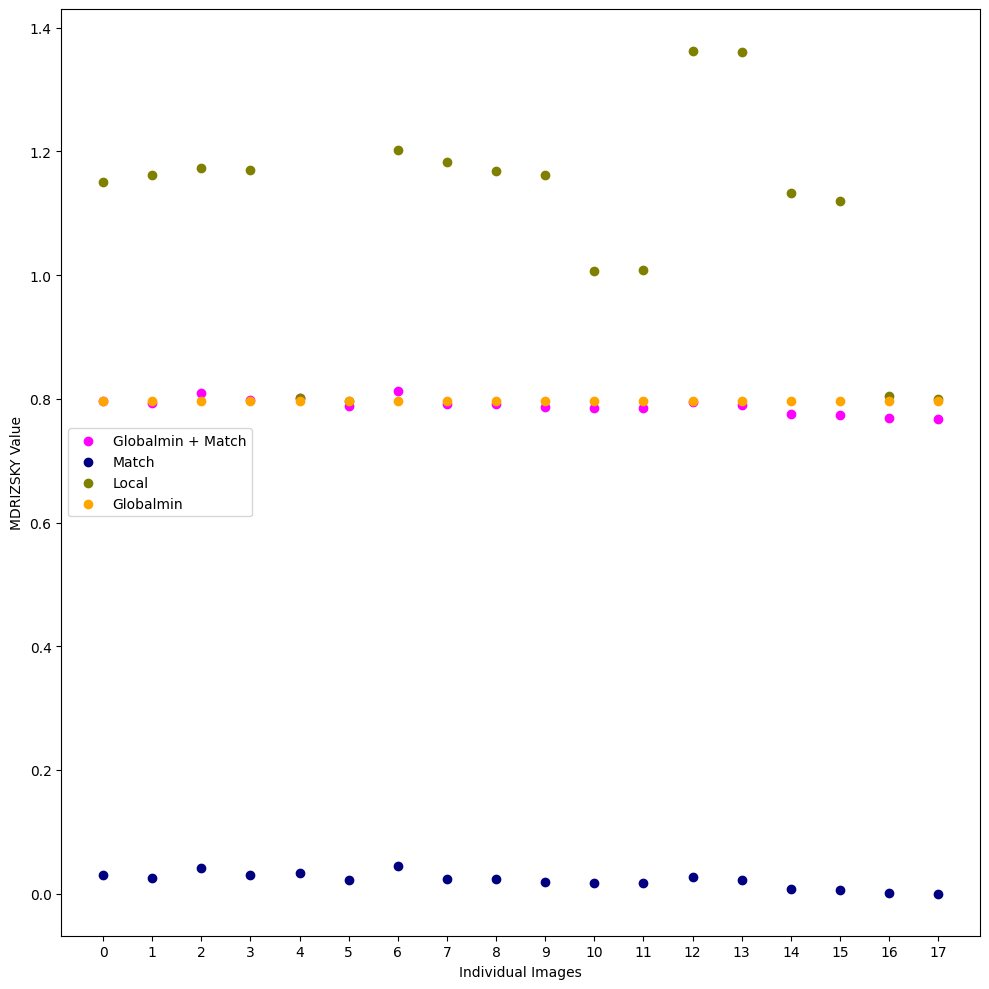

In [13]:
index = mdrizsky_val.index.tolist()
globalmin = list(mdrizsky_val['globalmin'])
globalmin_match = list(mdrizsky_val['globalmin_match'])
match = list(mdrizsky_val['match'])
local = list(mdrizsky_val['local'])

# Plotting code: 
fig = plt.figure(figsize=[10, 10])
plt.scatter(index, globalmin_match, color='magenta', label='Globalmin + Match')
plt.scatter(index, match, color='navy', label='Match')
plt.scatter(index, local, color='olive', label='Local')
plt.scatter(index, globalmin, color='orange', label='Globalmin')
plt.xlabel('Individual Images')
plt.ylabel('MDRIZSKY Value')
plt.legend(loc="center left")
plt.xticks(index)
plt.tight_layout()
plt.show()

## 5. Display the full 'matched' mosaic <a id="display"></a>

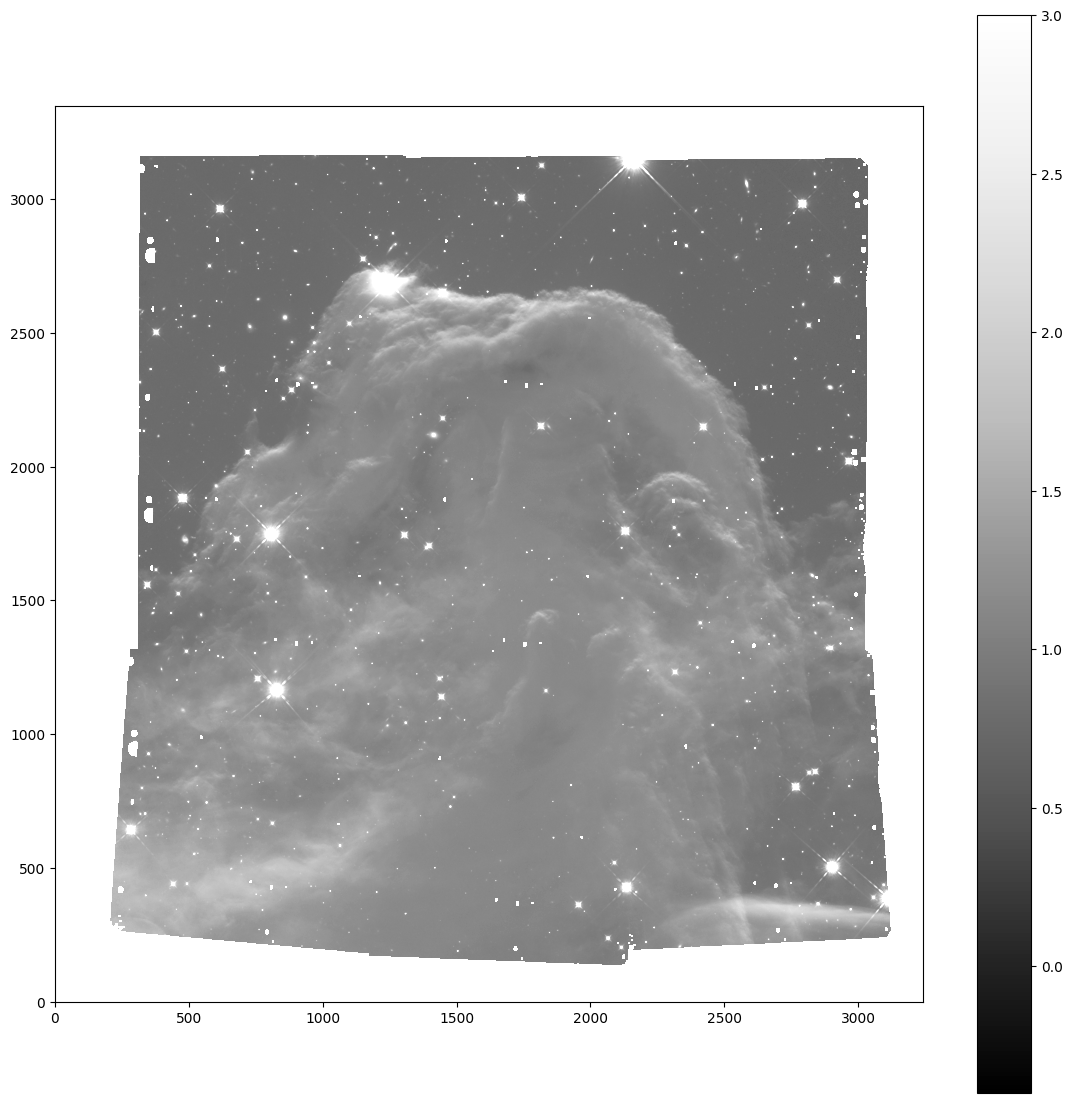

In [14]:
sci = fits.getdata('f160w_match_drz_sci.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=-0.4, vmax=3, cmap='Greys_r', origin='lower')
plt.colorbar()
plt.show()



    Author: C. Martlin & K.Huynh, STScI WFC3 Team
    Created: December 14, 2018
    Updated: December 22, 2023
    